In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.metrics import mse
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('LSTM-Multivariate_pollution.csv')
test_data = pd.read_csv('pollution_test_data1.csv')

train_data['wnd_dir'] = train_data['wnd_dir'].map({'SE':0,'cv':1,'NW':2,'NE':3})
test_data['wnd_dir'] = test_data['wnd_dir'].map({'SE':0,'cv':1,'NW':2,'NE':3})

train_data = train_data.drop(columns=['date'])
temp = train_data['pollution']
train_data = train_data.drop(columns=['pollution'])
train_data['pollution'] = temp
train_data.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,-4.0,1020.0,0,1.79,0,0,129.0
1,-15,-4.0,1020.0,0,2.68,0,0,148.0
2,-11,-5.0,1021.0,0,3.57,0,0,159.0
3,-7,-5.0,1022.0,0,5.36,1,0,181.0
4,-7,-5.0,1022.0,0,6.25,2,0,138.0


In [3]:
test_data.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,0,3.58,0,0,128
1,-17,5,1027,0,7.60,0,0,77
2,-16,4,1027,0,9.39,0,0,65
3,-16,1,1028,1,0.89,0,0,79
4,-14,0,1028,3,1.79,0,0,93


In [24]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)
print(scaled_train_data.shape, scaled_test_data.shape)

(43800, 8) (346, 8)


In [26]:
window = 24
X_train = []
Y_train = []
X_test = []
Y_test = []
for i in range(window,len(scaled_train_data)):
    X_train.append(scaled_train_data[i-window:i,:-1])
    Y_train.append(scaled_train_data[i,-1])
for i in range(window,len(scaled_test_data)):
    X_test.append(scaled_test_data[i-window:i,:-1])
    Y_test.append(scaled_test_data[i,-1])
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
print(X_train.shape,Y_train.shape, X_test.shape, Y_test.shape)

(43776, 24, 7) (43776,) (322, 24, 7) (322,)


In [28]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

In [29]:
model = Sequential([
    LSTM(7, return_sequences=True),
    LSTM(16, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stopping = EarlyStopping(monitor='val_mse', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, verbose=1, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 3/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 4/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 5/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 7/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 8/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 9/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/

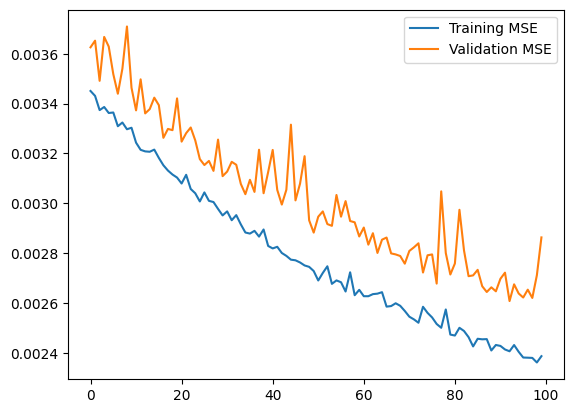

In [33]:
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()

In [34]:
pred = model.predict(X_test)
mse = mean_squared_error(pred, Y_test)
mse

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


0.002170365014738964

In [54]:
actual_Y = test_data['pollution']
actual_Y = actual_Y[24:]

In [55]:
temp = test_data.drop(columns=['pollution'])
temp = temp.iloc[24:,:]
temp['pollution'] = pred
temp = scaler.inverse_transform(temp)
actual_pred = temp[:,-1]

In [56]:
mean_squared_error(actual_Y, actual_pred)

2144.398767702627